# 3D trajectory

In this notebook, we construct the 3D trajectories of inner droplets by combining the X-Y plane tracking results and the simultaneous stage positions.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from skimage import io
from IPython.display import clear_output
import dufte
plt.style.use(dufte.style)
from fit_circle_utils import fit_sphere
from myImageLib import bestcolor

## 1 Construct xyz-traj

Save the combined trajectory.

In [20]:
folder = '/home/zhengyang/data/DE/07212021/2021-07-21_16h41m52s'
stagePosition = pd.read_csv(os.path.join(folder, 'StagePosition.txt'), delimiter='\t',
                            names=['name', 'x', 'y', 'z', 'UK1', 'UK2'])

xyPosition = pd.read_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'traj.csv'))

xyPosition = xyPosition.set_index('filename')
stagePosition = stagePosition.set_index('name')

In [21]:
mpp = 0.16
xyPosition['x'] *= mpp
xyPosition['y'] *= mpp
xyPosition['z'] = stagePosition['z']

In [22]:
xyz_traj = xyPosition[['x', 'y', 'z']]
xyz_traj.to_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'xyz-traj.csv'), float_format='%.1f')

## 2 Plot 3d trajectory

In [23]:
xyz_traj = pd.read_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'xyz-traj.csv')).set_index('filename')

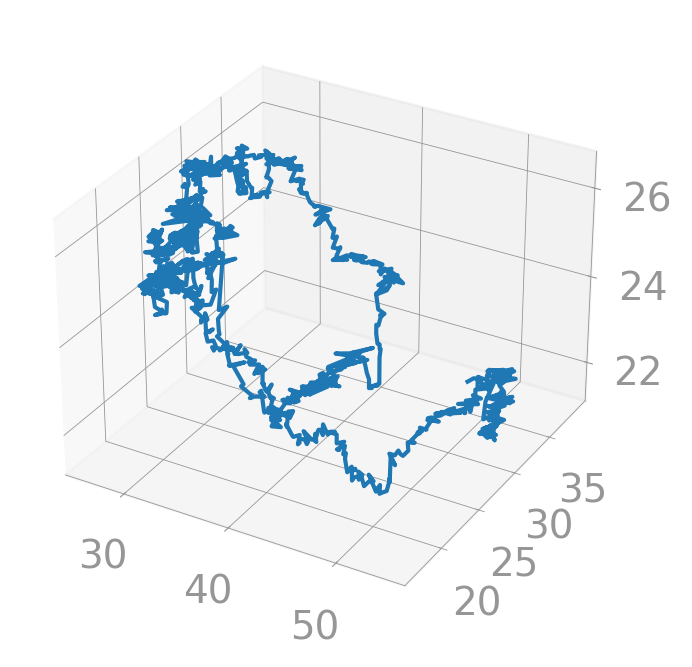

In [25]:
mpp = 0.16 # microns per pixel
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz_traj.x, xyz_traj.y, xyz_traj.z)
# ax.set_xlim((0, 102.4))
# ax.set_ylim((102.4, 0))

(40.0, 0.0)

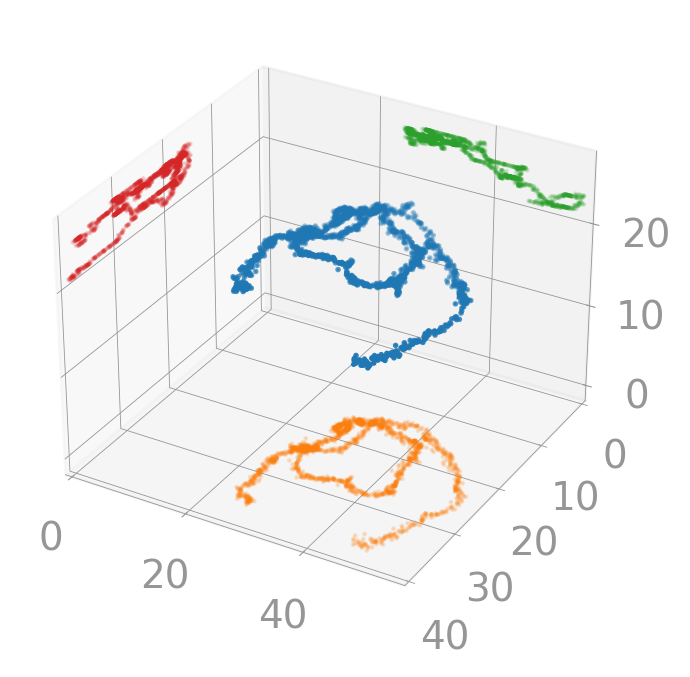

In [29]:
# try drawing the projections

mpp = 0.16 # microns per pixel
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_traj.x, xyz_traj.y, xyz_traj.z, 
           s=1, cmap='bwr')
ax.scatter(xyz_traj.x, xyz_traj.y, 0, 
       s=0.5, cmap='winter', alpha=0.2)
ax.scatter(xyz_traj.x, 0, xyz_traj.z, 
       s=0.5, cmap='winter', alpha=0.2)
ax.scatter(0, xyz_traj.y, xyz_traj.z, 
       s=0.5, cmap='winter', alpha=0.2)

# ax.set_xlim((0, 102.4))
ax.set_ylim((40, 0))

## 3D trajectory animation

### Fixed view, with projections

![3d traj projection demo](demo/3d-traj-projection-demo.gif)

In [30]:
# trajectory animation and video
mpp = 0.16 # microns per pixel
interval = 10 # plot skip
save_folder = os.path.join(folder, 'images', 'crop_HoughCircles', '3d-traj-animation')
image_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

for i in range(len(xyPosition)):
    if i % interval != 0:
        continue
    print('{0:d}/{1:d}, {2:.2f}%'.format(i, len(xyPosition), i/len(xyPosition)*100))
    clear_output(wait=True)
    xyPosition1 = xyz_traj[:i+1]
    zeros = np.zeros(len(xyPosition1))
    fig = plt.figure(figsize=(4, 2), dpi=150)
    ax = fig.add_axes([0,0,0.5,1], projection='3d')
    ax.plot(xyPosition1.x, xyPosition1.y, xyPosition1.z)

    ax.plot(xyPosition1.x, xyPosition1.y, zeros, ls=':')
    ax.plot(xyPosition1.x, zeros, xyPosition1.z, ls=':')
    ax.plot(zeros, xyPosition1.y, xyPosition1.z, ls=':')
    
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyPosition1.index[-1])))
    
    ax.set_xlim((0, img.shape[0]*mpp))
    ax.set_ylim((img.shape[1]*mpp, 0))
    ax.set_zlim((0, 1.1*xyPosition1.z.max()))
    
    ax2 = fig.add_axes([0.5,0,0.5,1])    
    ax2.imshow(img, cmap='gray')
    ax2.plot(xyPosition1.x.iloc[-1]/mpp, xyPosition1.iloc[-1].y/mpp, 
             mec='red', ls='', marker='o', mfc=(0,0,0,0), markersize=11)
    ax2.axis('off')
    fig.savefig(os.path.join(save_folder, '{:08d}.jpg'.format(xyPosition1.index[-1])))
    plt.close()

1800/1806, 99.67%


### Rotating view, reference outer droplet, no projections

Show the relative position between inner and outer droplets. 

![outer ref demo](demo/outer-ref-demo.gif)

In [43]:
traj = pd.read_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'xyz-traj.csv'))
# p = fit_sphere(traj.x[::100], traj.y[::100], traj.z[::100])
p = {'a': 223*mpp, 'b': 184*mpp, 'c': 10, 'r': 25.2}

In [45]:
save_folder = os.path.join(folder, 'images', 'crop_HoughCircles', '3d-traj-RVRef')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

a, b, c, r = p['a'], p['b'], p['c'], p['r']

for n, i in traj.iterrows():
    if n % 10 == 0:
        fig = plt.figure(figsize=(3, 3), dpi=300)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([a-r, a+r])
        ax.set_ylim([b+r, b-r])        
        ax.set_zlim([c-r, c+r])
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = r*np.cos(u)*np.sin(v) + a
        y = r*np.sin(u)*np.sin(v) + b
        z = r*np.cos(v) + c
        ax.plot_wireframe(x, y, z, color=(1, 0, 0, 0.3), lw=0.5, ls='--')
        ax.axis('off')
        ax.plot(traj.x[:n], traj.y[:n], traj.z[:n], color='black', lw=0.5, ls='-.')
        ax.scatter(traj.x[n], traj.y[n], traj.z[n], s=20, marker='o', color=bestcolor(1))
        ax.view_init(30, 360*n/len(traj))
        fig.savefig(os.path.join(save_folder, '{:04d}.jpg'.format(n)))
        plt.close()
        clear_output(wait=True)